# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[Sigmoid]


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# data = {
#      'X_train': # training data
#      'y_train': # training labels
#      'X_val': # validation data
#      'y_val': # validation labels
#    }

# model = MyAwesomeModel(hidden_size=100, reg=10)
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 101 / 4900) loss: 1.829613
(Iteration 201 / 4900) loss: 1.857390
(Iteration 301 / 4900) loss: 1.744448
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 501 / 4900) loss: 1.565913
(Iteration 601 / 4900) loss: 1.700510
(Iteration 701 / 4900) loss: 1.732213
(Iteration 801 / 4900) loss: 1.688361
(Iteration 901 / 4900) loss: 1.439529
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1101 / 4900) loss: 1.278401
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1301 / 4900) loss: 1.438847
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1501 / 4900) loss: 1.346286
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1701 / 4900) loss: 1.318215
(Iteration 1801 / 4900) loss: 1.395750
(Iteration 1901 / 4900) loss: 1.338233
(Epoch 4 / 10) t

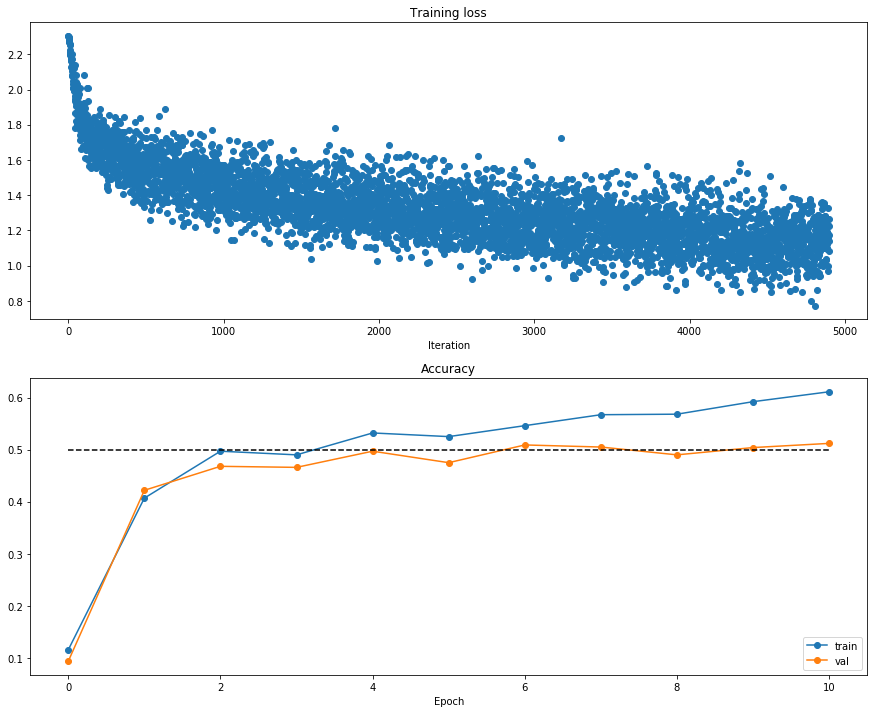

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)

  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 357422.248338
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.114000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.141000
(Epoch 2 / 20) train acc: 0.540000; val_acc: 0.142000
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.156000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.170000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.154000
(Iteration 11 / 40) loss: 2990.880358
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.152000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.146000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.150000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.142000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.142000
(Iteration 21 / 40) loss: 1934.093573
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.144000
(Iteration 31 /

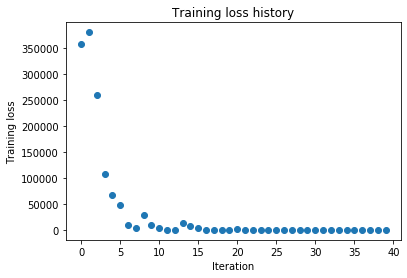

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1   # Experiment with this!
learning_rate = 1e-4  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 166.501707
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.101000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.122000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.106000
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.111000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.113000
(Iteration 11 / 40) loss: 3.343141
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.122000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.113000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.125000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.125000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.121000
(Iteration 21 / 40) loss: 0.039138
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.123000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.121000
(Iteration 31 / 40) loss

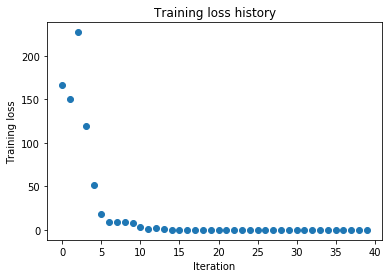

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 1e-1   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.107000
(Iteration 11 / 200) loss: 2.356069
(Iteration 21 / 200) loss: 2.214091
(Iteration 31 / 200) loss: 2.205928
(Epoch 1 / 5) train acc: 0.225000; val_acc: 0.193000
(Iteration 41 / 200) loss: 2.132095
(Iteration 51 / 200) loss: 2.118950
(Iteration 61 / 200) loss: 2.116443
(Iteration 71 / 200) loss: 2.132549
(Epoch 2 / 5) train acc: 0.298000; val_acc: 0.260000
(Iteration 81 / 200) loss: 1.977227
(Iteration 91 / 200) loss: 2.007528
(Iteration 101 / 200) loss: 2.004762
(Iteration 111 / 200) loss: 1.885342
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.287000
(Iteration 121 / 200) loss: 1.891517
(Iteration 131 / 200) loss: 1.923677
(Iteration 141 / 200) loss: 1.957743
(Iteration 151 / 200) loss: 1.966736
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.305000
(Iteration 161 / 200) loss: 1.801483
(Iteration 171 / 200) loss: 1.973779
(Iteration 181 / 200) loss: 1.666572
(Iteration 191 / 200) los

/Users/chao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/chao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/chao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlie

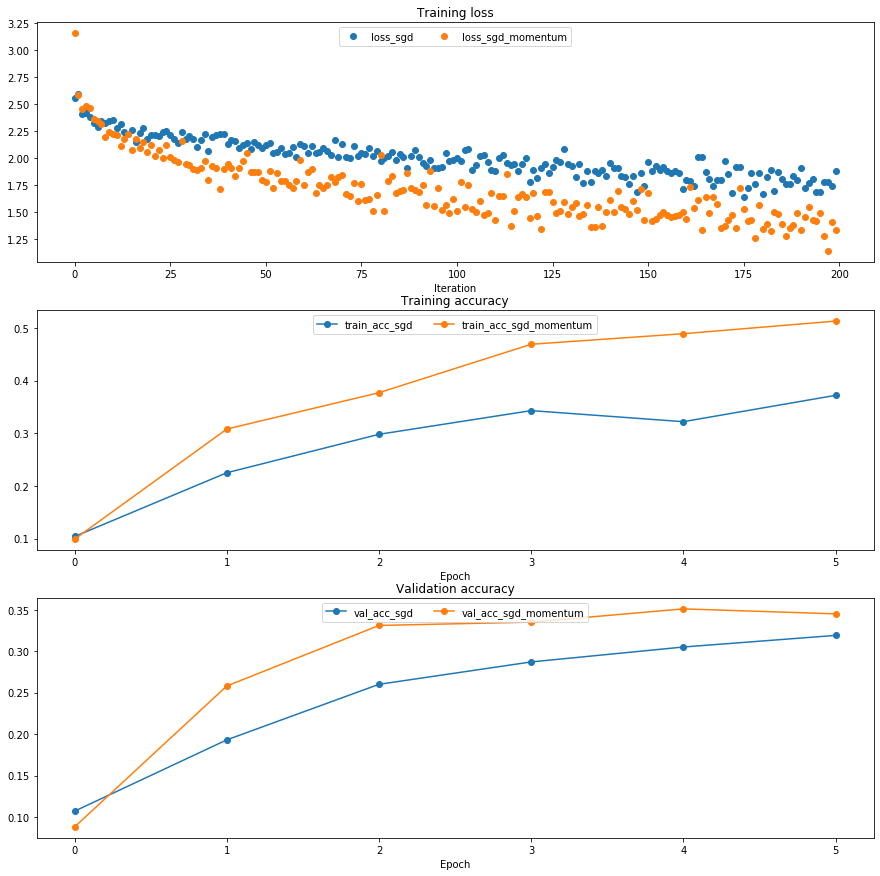

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [18]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505558
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519017
(Iteration 101 / 200) loss: 1.368523
(Iteration 111 / 200) loss: 1.470400
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199064
(Iteration 131 / 200) loss: 1.464705
(Iteration 141 / 200) loss: 1.359863
(Iteration 151 / 200) loss: 1.415068
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.382818
(Iteration 171 / 200) loss: 1.359900
(Iteration 181 / 200) loss: 1.095948
(Iteration 191 / 200) lo

/Users/chao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/chao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/chao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlie

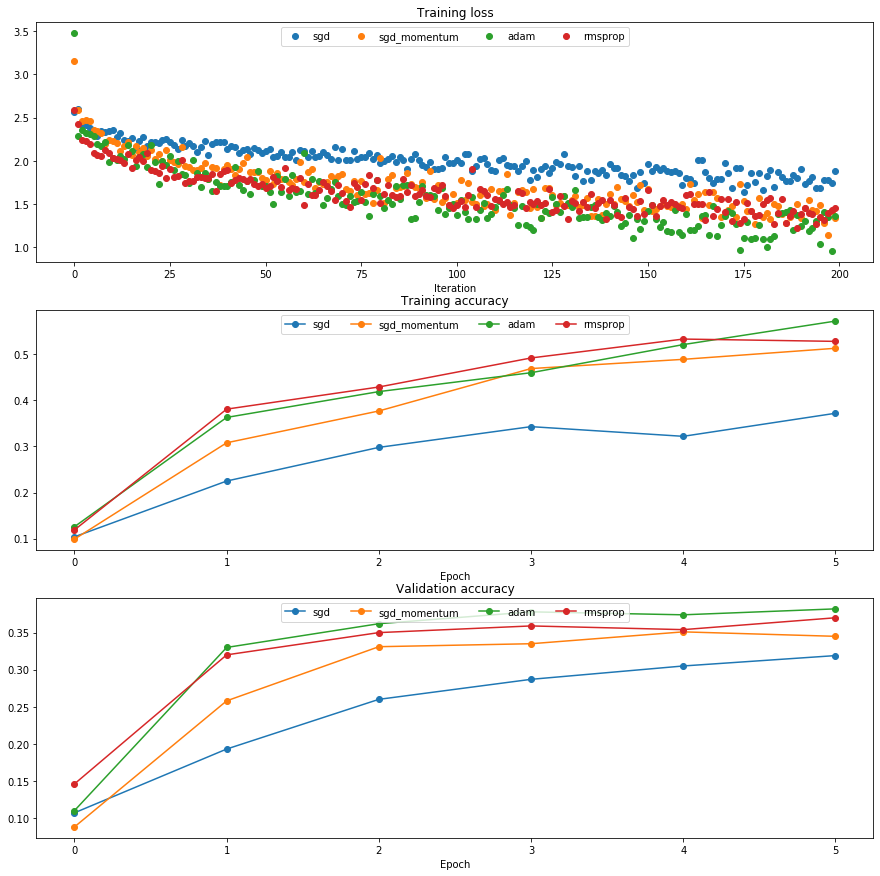

In [19]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
[FILL THIS IN]


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [24]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# print('running with adam')
# best_model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)
# solver = Solver(model, data,
#               num_epochs=5, batch_size=100,
#               update_rule='adam',
#               optim_config={
#                 'learning_rate': 5e-3,
#               },
#               verbose=True)
# solver.train()
# print()


# num_train = 49000
# small_data = {
#   'X_train': data['X_train'][:num_train],
#   'y_train': data['y_train'][:num_train],
#   'X_val': data['X_val'],
#   'y_val': data['y_val'],
# }

learning_rate = 1e-3
weight_scale = 6e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()
best_model = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 39200) loss: 10.208102
(Epoch 0 / 20) train acc: 0.098000; val_acc: 0.102000
(Iteration 11 / 39200) loss: 5.009920
(Iteration 21 / 39200) loss: 3.950527
(Iteration 31 / 39200) loss: 2.385159
(Iteration 41 / 39200) loss: 2.868901
(Iteration 51 / 39200) loss: 3.409550
(Iteration 61 / 39200) loss: 2.665362
(Iteration 71 / 39200) loss: 2.177579
(Iteration 81 / 39200) loss: 2.421387
(Iteration 91 / 39200) loss: 1.895219
(Iteration 101 / 39200) loss: 1.894715
(Iteration 111 / 39200) loss: 2.178091
(Iteration 121 / 39200) loss: 1.979814
(Iteration 131 / 39200) loss: 1.861434
(Iteration 141 / 39200) loss: 1.762026
(Iteration 151 / 39200) loss: 2.168991
(Iteration 161 / 39200) loss: 2.333642
(Iteration 171 / 39200) loss: 2.119978
(Iteration 181 / 39200) loss: 1.696520
(Iteration 191 / 39200) loss: 2.246474
(Iteration 201 / 39200) loss: 2.240929
(Iteration 211 / 39200) loss: 1.944134
(Iteration 221 / 39200) loss: 1.904805
(Iteration 231 / 39200) loss: 1.886591
(Iteration 241 / 392

(Iteration 2061 / 39200) loss: 1.568123
(Iteration 2071 / 39200) loss: 1.478660
(Iteration 2081 / 39200) loss: 1.325706
(Iteration 2091 / 39200) loss: 2.026267
(Iteration 2101 / 39200) loss: 1.903861
(Iteration 2111 / 39200) loss: 1.541448
(Iteration 2121 / 39200) loss: 1.381830
(Iteration 2131 / 39200) loss: 1.502484
(Iteration 2141 / 39200) loss: 1.765917
(Iteration 2151 / 39200) loss: 1.888965
(Iteration 2161 / 39200) loss: 1.892959
(Iteration 2171 / 39200) loss: 2.071110
(Iteration 2181 / 39200) loss: 1.816428
(Iteration 2191 / 39200) loss: 1.457916
(Iteration 2201 / 39200) loss: 1.830941
(Iteration 2211 / 39200) loss: 1.746817
(Iteration 2221 / 39200) loss: 1.592495
(Iteration 2231 / 39200) loss: 2.185996
(Iteration 2241 / 39200) loss: 1.647894
(Iteration 2251 / 39200) loss: 1.687299
(Iteration 2261 / 39200) loss: 1.358702
(Iteration 2271 / 39200) loss: 1.851899
(Iteration 2281 / 39200) loss: 1.528348
(Iteration 2291 / 39200) loss: 1.608089
(Iteration 2301 / 39200) loss: 1.780370


(Iteration 4101 / 39200) loss: 1.956243
(Iteration 4111 / 39200) loss: 1.554776
(Iteration 4121 / 39200) loss: 1.570319
(Iteration 4131 / 39200) loss: 1.336998
(Iteration 4141 / 39200) loss: 1.691934
(Iteration 4151 / 39200) loss: 1.657500
(Iteration 4161 / 39200) loss: 1.533905
(Iteration 4171 / 39200) loss: 1.174572
(Iteration 4181 / 39200) loss: 1.406080
(Iteration 4191 / 39200) loss: 1.667965
(Iteration 4201 / 39200) loss: 1.420052
(Iteration 4211 / 39200) loss: 1.748165
(Iteration 4221 / 39200) loss: 1.269944
(Iteration 4231 / 39200) loss: 1.635480
(Iteration 4241 / 39200) loss: 1.577081
(Iteration 4251 / 39200) loss: 1.764085
(Iteration 4261 / 39200) loss: 1.531435
(Iteration 4271 / 39200) loss: 1.156290
(Iteration 4281 / 39200) loss: 1.553580
(Iteration 4291 / 39200) loss: 1.649618
(Iteration 4301 / 39200) loss: 1.452871
(Iteration 4311 / 39200) loss: 1.633417
(Iteration 4321 / 39200) loss: 1.489686
(Iteration 4331 / 39200) loss: 1.433279
(Iteration 4341 / 39200) loss: 1.393188


(Iteration 6171 / 39200) loss: 1.861704
(Iteration 6181 / 39200) loss: 1.438138
(Iteration 6191 / 39200) loss: 1.456116
(Iteration 6201 / 39200) loss: 1.467114
(Iteration 6211 / 39200) loss: 1.803202
(Iteration 6221 / 39200) loss: 0.937479
(Iteration 6231 / 39200) loss: 1.834969
(Iteration 6241 / 39200) loss: 1.423300
(Iteration 6251 / 39200) loss: 1.535634
(Iteration 6261 / 39200) loss: 1.626914
(Iteration 6271 / 39200) loss: 1.708977
(Iteration 6281 / 39200) loss: 1.049235
(Iteration 6291 / 39200) loss: 1.784967
(Iteration 6301 / 39200) loss: 1.161273
(Iteration 6311 / 39200) loss: 1.609976
(Iteration 6321 / 39200) loss: 1.366340
(Iteration 6331 / 39200) loss: 1.274263
(Iteration 6341 / 39200) loss: 1.365143
(Iteration 6351 / 39200) loss: 1.110548
(Iteration 6361 / 39200) loss: 1.421352
(Iteration 6371 / 39200) loss: 1.217904
(Iteration 6381 / 39200) loss: 1.586857
(Iteration 6391 / 39200) loss: 1.167104
(Iteration 6401 / 39200) loss: 1.597931
(Iteration 6411 / 39200) loss: 1.739151


(Iteration 8211 / 39200) loss: 1.253690
(Iteration 8221 / 39200) loss: 1.375920
(Iteration 8231 / 39200) loss: 1.877788
(Iteration 8241 / 39200) loss: 1.411571
(Iteration 8251 / 39200) loss: 1.287889
(Iteration 8261 / 39200) loss: 1.451875
(Iteration 8271 / 39200) loss: 1.587127
(Iteration 8281 / 39200) loss: 1.130970
(Iteration 8291 / 39200) loss: 1.525185
(Iteration 8301 / 39200) loss: 1.194868
(Iteration 8311 / 39200) loss: 1.377812
(Iteration 8321 / 39200) loss: 1.293938
(Iteration 8331 / 39200) loss: 1.223178
(Iteration 8341 / 39200) loss: 1.546007
(Iteration 8351 / 39200) loss: 1.930438
(Iteration 8361 / 39200) loss: 0.999715
(Iteration 8371 / 39200) loss: 1.689691
(Iteration 8381 / 39200) loss: 1.151684
(Iteration 8391 / 39200) loss: 1.507179
(Iteration 8401 / 39200) loss: 1.165551
(Iteration 8411 / 39200) loss: 1.291307
(Iteration 8421 / 39200) loss: 1.087998
(Iteration 8431 / 39200) loss: 1.103304
(Iteration 8441 / 39200) loss: 1.247082
(Iteration 8451 / 39200) loss: 1.716149


(Iteration 10261 / 39200) loss: 1.617668
(Iteration 10271 / 39200) loss: 1.665194
(Iteration 10281 / 39200) loss: 1.291790
(Iteration 10291 / 39200) loss: 1.563812
(Iteration 10301 / 39200) loss: 1.084402
(Iteration 10311 / 39200) loss: 1.357887
(Iteration 10321 / 39200) loss: 1.276727
(Iteration 10331 / 39200) loss: 1.213357
(Iteration 10341 / 39200) loss: 1.343628
(Iteration 10351 / 39200) loss: 1.589149
(Iteration 10361 / 39200) loss: 0.894489
(Iteration 10371 / 39200) loss: 1.111989
(Iteration 10381 / 39200) loss: 1.260626
(Iteration 10391 / 39200) loss: 0.952129
(Iteration 10401 / 39200) loss: 1.378963
(Iteration 10411 / 39200) loss: 1.584517
(Iteration 10421 / 39200) loss: 1.344283
(Iteration 10431 / 39200) loss: 1.706102
(Iteration 10441 / 39200) loss: 1.788024
(Iteration 10451 / 39200) loss: 1.808097
(Iteration 10461 / 39200) loss: 1.316287
(Iteration 10471 / 39200) loss: 1.029624
(Iteration 10481 / 39200) loss: 1.566601
(Iteration 10491 / 39200) loss: 1.170488
(Iteration 10501

(Iteration 12251 / 39200) loss: 1.362392
(Iteration 12261 / 39200) loss: 1.453351
(Iteration 12271 / 39200) loss: 1.344071
(Iteration 12281 / 39200) loss: 0.967218
(Iteration 12291 / 39200) loss: 1.193867
(Iteration 12301 / 39200) loss: 1.009972
(Iteration 12311 / 39200) loss: 1.362515
(Iteration 12321 / 39200) loss: 1.369226
(Iteration 12331 / 39200) loss: 1.280401
(Iteration 12341 / 39200) loss: 1.490679
(Iteration 12351 / 39200) loss: 1.544935
(Iteration 12361 / 39200) loss: 1.117015
(Iteration 12371 / 39200) loss: 0.939294
(Iteration 12381 / 39200) loss: 1.337920
(Iteration 12391 / 39200) loss: 1.419225
(Iteration 12401 / 39200) loss: 1.417042
(Iteration 12411 / 39200) loss: 1.261037
(Iteration 12421 / 39200) loss: 1.705661
(Iteration 12431 / 39200) loss: 1.702908
(Iteration 12441 / 39200) loss: 1.161969
(Iteration 12451 / 39200) loss: 1.231957
(Iteration 12461 / 39200) loss: 1.397024
(Iteration 12471 / 39200) loss: 1.167194
(Iteration 12481 / 39200) loss: 1.856096
(Iteration 12491

(Iteration 14261 / 39200) loss: 0.980554
(Iteration 14271 / 39200) loss: 1.113524
(Iteration 14281 / 39200) loss: 1.550903
(Iteration 14291 / 39200) loss: 1.085198
(Iteration 14301 / 39200) loss: 1.309729
(Iteration 14311 / 39200) loss: 1.044541
(Iteration 14321 / 39200) loss: 0.951500
(Iteration 14331 / 39200) loss: 1.406895
(Iteration 14341 / 39200) loss: 1.011752
(Iteration 14351 / 39200) loss: 1.260342
(Iteration 14361 / 39200) loss: 1.298040
(Iteration 14371 / 39200) loss: 1.196278
(Iteration 14381 / 39200) loss: 1.112107
(Iteration 14391 / 39200) loss: 1.164601
(Iteration 14401 / 39200) loss: 1.146448
(Iteration 14411 / 39200) loss: 1.456275
(Iteration 14421 / 39200) loss: 1.156961
(Iteration 14431 / 39200) loss: 1.086985
(Iteration 14441 / 39200) loss: 1.359357
(Iteration 14451 / 39200) loss: 1.106872
(Iteration 14461 / 39200) loss: 1.132713
(Iteration 14471 / 39200) loss: 0.896007
(Iteration 14481 / 39200) loss: 1.296799
(Iteration 14491 / 39200) loss: 1.175391
(Iteration 14501

(Iteration 16261 / 39200) loss: 1.551426
(Iteration 16271 / 39200) loss: 1.299316
(Iteration 16281 / 39200) loss: 1.542559
(Iteration 16291 / 39200) loss: 0.706003
(Iteration 16301 / 39200) loss: 1.255061
(Iteration 16311 / 39200) loss: 1.717545
(Iteration 16321 / 39200) loss: 0.999222
(Iteration 16331 / 39200) loss: 1.467695
(Iteration 16341 / 39200) loss: 1.375594
(Iteration 16351 / 39200) loss: 1.825821
(Iteration 16361 / 39200) loss: 1.107599
(Iteration 16371 / 39200) loss: 1.009019
(Iteration 16381 / 39200) loss: 1.150112
(Iteration 16391 / 39200) loss: 1.434263
(Iteration 16401 / 39200) loss: 1.597197
(Iteration 16411 / 39200) loss: 1.646024
(Iteration 16421 / 39200) loss: 1.129619
(Iteration 16431 / 39200) loss: 1.264486
(Iteration 16441 / 39200) loss: 1.649767
(Iteration 16451 / 39200) loss: 1.247214
(Iteration 16461 / 39200) loss: 1.076923
(Iteration 16471 / 39200) loss: 0.962165
(Iteration 16481 / 39200) loss: 1.478009
(Iteration 16491 / 39200) loss: 1.545777
(Iteration 16501

(Iteration 18271 / 39200) loss: 1.547608
(Iteration 18281 / 39200) loss: 1.885328
(Iteration 18291 / 39200) loss: 1.545998
(Iteration 18301 / 39200) loss: 1.316603
(Iteration 18311 / 39200) loss: 1.504218
(Iteration 18321 / 39200) loss: 0.965326
(Iteration 18331 / 39200) loss: 1.159668
(Iteration 18341 / 39200) loss: 1.922315
(Iteration 18351 / 39200) loss: 1.065258
(Iteration 18361 / 39200) loss: 1.377857
(Iteration 18371 / 39200) loss: 1.019603
(Iteration 18381 / 39200) loss: 1.303055
(Iteration 18391 / 39200) loss: 1.409406
(Iteration 18401 / 39200) loss: 1.167059
(Iteration 18411 / 39200) loss: 1.641124
(Iteration 18421 / 39200) loss: 1.267484
(Iteration 18431 / 39200) loss: 1.048645
(Iteration 18441 / 39200) loss: 1.699059
(Iteration 18451 / 39200) loss: 1.272855
(Iteration 18461 / 39200) loss: 1.330619
(Iteration 18471 / 39200) loss: 1.418415
(Iteration 18481 / 39200) loss: 1.124669
(Iteration 18491 / 39200) loss: 1.474947
(Iteration 18501 / 39200) loss: 1.340538
(Iteration 18511

(Iteration 20261 / 39200) loss: 1.437224
(Iteration 20271 / 39200) loss: 1.313882
(Iteration 20281 / 39200) loss: 1.688034
(Iteration 20291 / 39200) loss: 1.146354
(Iteration 20301 / 39200) loss: 1.157618
(Iteration 20311 / 39200) loss: 1.384613
(Iteration 20321 / 39200) loss: 1.078247
(Iteration 20331 / 39200) loss: 1.040702
(Iteration 20341 / 39200) loss: 1.564113
(Iteration 20351 / 39200) loss: 1.407396
(Iteration 20361 / 39200) loss: 1.070644
(Iteration 20371 / 39200) loss: 1.274442
(Iteration 20381 / 39200) loss: 1.063583
(Iteration 20391 / 39200) loss: 1.395026
(Iteration 20401 / 39200) loss: 1.188159
(Iteration 20411 / 39200) loss: 1.480919
(Iteration 20421 / 39200) loss: 1.234055
(Iteration 20431 / 39200) loss: 0.995278
(Iteration 20441 / 39200) loss: 0.829024
(Iteration 20451 / 39200) loss: 1.138234
(Iteration 20461 / 39200) loss: 1.081575
(Iteration 20471 / 39200) loss: 0.859854
(Iteration 20481 / 39200) loss: 1.292705
(Iteration 20491 / 39200) loss: 1.311469
(Iteration 20501

(Iteration 22261 / 39200) loss: 1.345558
(Iteration 22271 / 39200) loss: 1.665789
(Iteration 22281 / 39200) loss: 1.255218
(Iteration 22291 / 39200) loss: 1.206589
(Iteration 22301 / 39200) loss: 1.801805
(Iteration 22311 / 39200) loss: 1.231887
(Iteration 22321 / 39200) loss: 1.559053
(Iteration 22331 / 39200) loss: 1.128766
(Iteration 22341 / 39200) loss: 0.805031
(Iteration 22351 / 39200) loss: 0.999681
(Iteration 22361 / 39200) loss: 1.006676
(Iteration 22371 / 39200) loss: 1.769801
(Iteration 22381 / 39200) loss: 1.688459
(Iteration 22391 / 39200) loss: 1.281429
(Iteration 22401 / 39200) loss: 1.390315
(Iteration 22411 / 39200) loss: 1.153613
(Iteration 22421 / 39200) loss: 1.468002
(Iteration 22431 / 39200) loss: 1.195223
(Iteration 22441 / 39200) loss: 1.623234
(Iteration 22451 / 39200) loss: 1.192388
(Iteration 22461 / 39200) loss: 0.880981
(Iteration 22471 / 39200) loss: 1.093127
(Iteration 22481 / 39200) loss: 1.018827
(Iteration 22491 / 39200) loss: 1.720415
(Iteration 22501

(Iteration 24251 / 39200) loss: 1.255704
(Iteration 24261 / 39200) loss: 1.735766
(Iteration 24271 / 39200) loss: 1.399964
(Iteration 24281 / 39200) loss: 1.054936
(Iteration 24291 / 39200) loss: 0.989518
(Iteration 24301 / 39200) loss: 1.220805
(Iteration 24311 / 39200) loss: 1.098440
(Iteration 24321 / 39200) loss: 1.540144
(Iteration 24331 / 39200) loss: 1.935063
(Iteration 24341 / 39200) loss: 1.457414
(Iteration 24351 / 39200) loss: 1.293337
(Iteration 24361 / 39200) loss: 0.887799
(Iteration 24371 / 39200) loss: 1.199980
(Iteration 24381 / 39200) loss: 1.008925
(Iteration 24391 / 39200) loss: 1.222230
(Iteration 24401 / 39200) loss: 1.154461
(Iteration 24411 / 39200) loss: 1.308371
(Iteration 24421 / 39200) loss: 0.923718
(Iteration 24431 / 39200) loss: 1.287035
(Iteration 24441 / 39200) loss: 1.171149
(Iteration 24451 / 39200) loss: 1.704351
(Iteration 24461 / 39200) loss: 1.036916
(Iteration 24471 / 39200) loss: 1.137223
(Iteration 24481 / 39200) loss: 1.260361
(Iteration 24491

(Iteration 26261 / 39200) loss: 1.576810
(Iteration 26271 / 39200) loss: 0.953156
(Iteration 26281 / 39200) loss: 1.091168
(Iteration 26291 / 39200) loss: 1.257904
(Iteration 26301 / 39200) loss: 0.975000
(Iteration 26311 / 39200) loss: 1.390019
(Iteration 26321 / 39200) loss: 0.981735
(Iteration 26331 / 39200) loss: 0.833716
(Iteration 26341 / 39200) loss: 0.972182
(Iteration 26351 / 39200) loss: 1.189898
(Iteration 26361 / 39200) loss: 1.009610
(Iteration 26371 / 39200) loss: 0.995883
(Iteration 26381 / 39200) loss: 1.219511
(Iteration 26391 / 39200) loss: 1.541919
(Iteration 26401 / 39200) loss: 1.147732
(Iteration 26411 / 39200) loss: 1.255812
(Iteration 26421 / 39200) loss: 1.046737
(Iteration 26431 / 39200) loss: 0.973535
(Iteration 26441 / 39200) loss: 1.009488
(Iteration 26451 / 39200) loss: 1.227780
(Iteration 26461 / 39200) loss: 0.991934
(Iteration 26471 / 39200) loss: 0.695090
(Iteration 26481 / 39200) loss: 0.897303
(Iteration 26491 / 39200) loss: 1.248525
(Iteration 26501

(Iteration 28261 / 39200) loss: 0.926144
(Iteration 28271 / 39200) loss: 1.442735
(Iteration 28281 / 39200) loss: 1.230705
(Iteration 28291 / 39200) loss: 1.125066
(Iteration 28301 / 39200) loss: 1.293947
(Iteration 28311 / 39200) loss: 1.004149
(Iteration 28321 / 39200) loss: 1.542379
(Iteration 28331 / 39200) loss: 0.838949
(Iteration 28341 / 39200) loss: 1.233175
(Iteration 28351 / 39200) loss: 1.291673
(Iteration 28361 / 39200) loss: 1.054467
(Iteration 28371 / 39200) loss: 0.857116
(Iteration 28381 / 39200) loss: 0.475928
(Iteration 28391 / 39200) loss: 1.104176
(Iteration 28401 / 39200) loss: 0.927732
(Iteration 28411 / 39200) loss: 1.426068
(Iteration 28421 / 39200) loss: 0.972946
(Iteration 28431 / 39200) loss: 0.986565
(Iteration 28441 / 39200) loss: 1.331183
(Iteration 28451 / 39200) loss: 1.444660
(Iteration 28461 / 39200) loss: 1.199217
(Iteration 28471 / 39200) loss: 1.340430
(Iteration 28481 / 39200) loss: 1.067759
(Iteration 28491 / 39200) loss: 1.046180
(Iteration 28501

(Iteration 30271 / 39200) loss: 1.378194
(Iteration 30281 / 39200) loss: 1.327745
(Iteration 30291 / 39200) loss: 0.977696
(Iteration 30301 / 39200) loss: 1.527822
(Iteration 30311 / 39200) loss: 1.194016
(Iteration 30321 / 39200) loss: 1.067084
(Iteration 30331 / 39200) loss: 1.333808
(Iteration 30341 / 39200) loss: 1.547329
(Iteration 30351 / 39200) loss: 0.933461
(Iteration 30361 / 39200) loss: 0.793421
(Iteration 30371 / 39200) loss: 1.333760
(Iteration 30381 / 39200) loss: 1.271900
(Iteration 30391 / 39200) loss: 1.409909
(Iteration 30401 / 39200) loss: 0.882206
(Iteration 30411 / 39200) loss: 1.169538
(Iteration 30421 / 39200) loss: 1.414872
(Iteration 30431 / 39200) loss: 1.170468
(Iteration 30441 / 39200) loss: 1.182169
(Iteration 30451 / 39200) loss: 1.372464
(Iteration 30461 / 39200) loss: 1.147406
(Iteration 30471 / 39200) loss: 1.338387
(Iteration 30481 / 39200) loss: 0.996222
(Iteration 30491 / 39200) loss: 1.234216
(Iteration 30501 / 39200) loss: 1.374848
(Iteration 30511

(Iteration 32281 / 39200) loss: 0.827787
(Iteration 32291 / 39200) loss: 0.951990
(Iteration 32301 / 39200) loss: 0.822302
(Iteration 32311 / 39200) loss: 1.121088
(Iteration 32321 / 39200) loss: 1.090223
(Iteration 32331 / 39200) loss: 1.183337
(Iteration 32341 / 39200) loss: 1.137447
(Iteration 32351 / 39200) loss: 1.079611
(Iteration 32361 / 39200) loss: 1.377269
(Iteration 32371 / 39200) loss: 1.590645
(Iteration 32381 / 39200) loss: 1.108534
(Iteration 32391 / 39200) loss: 0.949559
(Iteration 32401 / 39200) loss: 1.163912
(Iteration 32411 / 39200) loss: 0.911599
(Iteration 32421 / 39200) loss: 1.083337
(Iteration 32431 / 39200) loss: 0.928242
(Iteration 32441 / 39200) loss: 0.766186
(Iteration 32451 / 39200) loss: 1.060732
(Iteration 32461 / 39200) loss: 1.259829
(Iteration 32471 / 39200) loss: 0.975505
(Iteration 32481 / 39200) loss: 1.276016
(Iteration 32491 / 39200) loss: 0.695747
(Iteration 32501 / 39200) loss: 1.460189
(Iteration 32511 / 39200) loss: 1.162515
(Iteration 32521

(Iteration 34301 / 39200) loss: 0.963673
(Iteration 34311 / 39200) loss: 0.911062
(Iteration 34321 / 39200) loss: 1.374544
(Iteration 34331 / 39200) loss: 1.181592
(Iteration 34341 / 39200) loss: 1.103300
(Iteration 34351 / 39200) loss: 1.001810
(Iteration 34361 / 39200) loss: 1.150284
(Iteration 34371 / 39200) loss: 1.496640
(Iteration 34381 / 39200) loss: 1.051836
(Iteration 34391 / 39200) loss: 0.946875
(Iteration 34401 / 39200) loss: 0.960170
(Iteration 34411 / 39200) loss: 1.197916
(Iteration 34421 / 39200) loss: 0.830418
(Iteration 34431 / 39200) loss: 1.366863
(Iteration 34441 / 39200) loss: 1.091254
(Iteration 34451 / 39200) loss: 1.813331
(Iteration 34461 / 39200) loss: 1.281473
(Iteration 34471 / 39200) loss: 1.003679
(Iteration 34481 / 39200) loss: 1.258869
(Iteration 34491 / 39200) loss: 0.786494
(Iteration 34501 / 39200) loss: 0.925204
(Iteration 34511 / 39200) loss: 1.307572
(Iteration 34521 / 39200) loss: 1.289621
(Iteration 34531 / 39200) loss: 1.110131
(Iteration 34541

(Iteration 36291 / 39200) loss: 1.373165
(Iteration 36301 / 39200) loss: 1.119941
(Iteration 36311 / 39200) loss: 1.721800
(Iteration 36321 / 39200) loss: 0.979319
(Iteration 36331 / 39200) loss: 1.221397
(Iteration 36341 / 39200) loss: 1.242653
(Iteration 36351 / 39200) loss: 0.747627
(Iteration 36361 / 39200) loss: 0.827148
(Iteration 36371 / 39200) loss: 1.003098
(Iteration 36381 / 39200) loss: 0.824930
(Iteration 36391 / 39200) loss: 0.917015
(Iteration 36401 / 39200) loss: 1.349387
(Iteration 36411 / 39200) loss: 1.029364
(Iteration 36421 / 39200) loss: 1.031120
(Iteration 36431 / 39200) loss: 0.834751
(Iteration 36441 / 39200) loss: 1.277663
(Iteration 36451 / 39200) loss: 0.945243
(Iteration 36461 / 39200) loss: 0.979864
(Iteration 36471 / 39200) loss: 1.105080
(Iteration 36481 / 39200) loss: 1.428566
(Iteration 36491 / 39200) loss: 0.842863
(Iteration 36501 / 39200) loss: 0.932252
(Iteration 36511 / 39200) loss: 0.916653
(Iteration 36521 / 39200) loss: 1.433250
(Iteration 36531

(Iteration 38281 / 39200) loss: 1.018872
(Iteration 38291 / 39200) loss: 0.880712
(Iteration 38301 / 39200) loss: 1.315409
(Iteration 38311 / 39200) loss: 0.943976
(Iteration 38321 / 39200) loss: 0.687727
(Iteration 38331 / 39200) loss: 0.879429
(Iteration 38341 / 39200) loss: 1.015439
(Iteration 38351 / 39200) loss: 1.166578
(Iteration 38361 / 39200) loss: 1.125125
(Iteration 38371 / 39200) loss: 1.020171
(Iteration 38381 / 39200) loss: 0.766146
(Iteration 38391 / 39200) loss: 1.103020
(Iteration 38401 / 39200) loss: 1.058677
(Iteration 38411 / 39200) loss: 0.865217
(Iteration 38421 / 39200) loss: 0.932319
(Iteration 38431 / 39200) loss: 0.577669
(Iteration 38441 / 39200) loss: 0.954008
(Iteration 38451 / 39200) loss: 1.126976
(Iteration 38461 / 39200) loss: 1.055432
(Iteration 38471 / 39200) loss: 0.495112
(Iteration 38481 / 39200) loss: 1.301490
(Iteration 38491 / 39200) loss: 0.821947
(Iteration 38501 / 39200) loss: 1.145414
(Iteration 38511 / 39200) loss: 0.973422
(Iteration 38521

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [26]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.526
Test set accuracy:  0.501
